In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputRegressor

### Helper Functions

In [2]:
def loadData(file):
    data = pd.read_csv(file)
    print('Raw shape: ',data.shape)
    data['Date'] = pd.to_datetime(data.Date)
    data['DOLocationID'] = data['DOLocationID'].astype(str)
    print('Days: ',len(set(data.Date)))
    return data

In [3]:
def getTimeSeries(df):
    table = pd.pivot_table(df, values='vehicle_count', index=['Date','Hour'],
                    columns=['DOLocationID'], aggfunc=np.sum, fill_value=0)
    return table

In [4]:
def zscoreNormalizeSpatial(matrix):
    m = matrix.copy()
    for i in range(m.shape[0]):
        m[i, :] = (m[i, :] - m[i, :].mean()) / (m[i, :].std()+1e-10)
        
    return m

In [5]:
def standardize(matrix):
    m = matrix.copy()
    scaler = StandardScaler()
    scaler.fit(m)
    t = scaler.transform(m)
    return scaler, t

In [6]:
def inverse_standardize(matrix, scaler):
    t = matrix.copy()
    return scaler.inverse_transform(t)

In [7]:
def addLag(dataset, maxlag, lagColumns):
    dataset_list = [dataset]

    for l in range(1, maxlag+1):
        df = dataset.shift(l)
        df = df[lagColumns]
        df.columns = [c+'_lag_'+str(l) for c in df.columns]
        dataset_list.append(df)

    dataset = pd.concat(dataset_list, axis=1).dropna()
    return dataset

In [8]:
def get_rmse(matrix1, matrix2):
    sumSquareError = np.mean(np.power(matrix1 - matrix2,2))
    rmse = np.power(sumSquareError,0.5)
    return rmse

In [9]:
def get_weights(rawdata, zontoBorough):
    
    rawdata['Borough'] = rawdata['DOLocationID'].apply(lambda x:zontoBorough[x])
    
    borough_df = rawdata[['vehicle_count','Borough']].groupby(by='Borough').sum().reset_index()

    zone_df = rawdata[['vehicle_count','DOLocationID']].groupby(by='DOLocationID').sum().reset_index()

    zone_df['Borough'] = zone_df['DOLocationID'].apply(lambda x:zontoBorough[x])

    zone_df = pd.merge(borough_df, zone_df, on=['Borough'], how='inner')

    zone_df['zone_weight'] = zone_df.vehicle_count_y / zone_df.vehicle_count_x

    zone_df = zone_df[['Borough', 'DOLocationID', 'zone_weight']]

    return zone_df

#### Load Raw Data

In [10]:
hub = 'Jfk'
tune_hyp_params = False

In [11]:
dataDir = '/home/urwa/Documents/Projects/NYU Remote/project/data/processedData/'
file = dataDir + hub + 'VehiceByHour.csv'

In [12]:
rawdata = loadData(file)

Raw shape:  (2260080, 4)
Days:  365


In [13]:
rawdata.head(2)

,DOLocationID,Date,Hour,vehicle_count
0,1,2018-01-01,0,1.0
1,2,2018-01-01,0,0.0


In [14]:
edge_data = getTimeSeries(rawdata)
# edge_data = edge_data.reset_index()
edge_data.head(3)

DOLocationID     1  10  100  101  102  106  107  108  109  11 ...  90  91  92  \
Date       Hour                                               ...               
2018-01-01 0     1   7    0    0    0    1    2    1    0   0 ...   3   1   1   
           1     0   4    0    1    0    1    4    0    0   0 ...   3   4   1   
           2     0   1    0    0    0    0    0    0    0   0 ...   0   0   0   

DOLocationID     93  94  95  96  97  98  99  
Date       Hour                              
2018-01-01 0      0   1   6   0   1   0   0  
           1      0   0   2   0   0   0   0  
           2      0   0   1   0   0   0   0  

[3 rows x 258 columns]

### Burrough Level Aggregation

In [15]:
zones = pd.read_csv('/home/urwa/Documents/Projects/NYU Remote/project/UrbanTemporalNetworks/Data/taxi_zones.csv')
zones['LocationID'] = zones['LocationID'].astype(str)
zones.head(2)

,OBJECTID,Shape_Leng,the_geom,Shape_Area,zone,LocationID,borough
0,1,0.116357,MULTIPOLYGON (((-74.18445299999996 40.69499599...,0.000782,Newark Airport,1,EWR
1,2,0.433470,MULTIPOLYGON (((-73.82337597260663 40.63898704...,0.004866,Jamaica Bay,2,Queens


In [16]:
zontoBorough = dict(zip(zones.LocationID.values,zones.borough.values))

In [17]:
borough_data = rawdata.copy(deep=True)
borough_data['DOLocationID'] = borough_data['DOLocationID'].apply(lambda x:zontoBorough[x])
borough_data.head(2)

,DOLocationID,Date,Hour,vehicle_count
0,EWR,2018-01-01,0,1.0
1,Queens,2018-01-01,0,0.0


In [18]:
borough_data = getTimeSeries(borough_data)
# borough_data = borough_data.reset_index()
borough_data.head(2)

DOLocationID     Bronx  Brooklyn  EWR  Manhattan  Queens  Staten Island
Date       Hour                                                        
2018-01-01 0        11       126    1        133     113              1
           1         9        90    0         71      62              2

In [19]:
zone_weights = get_weights(rawdata, zontoBorough)
zone_weights.head(2)

,Borough,DOLocationID,zone_weight
0,Bronx,119,0.023945
1,Bronx,126,0.012654


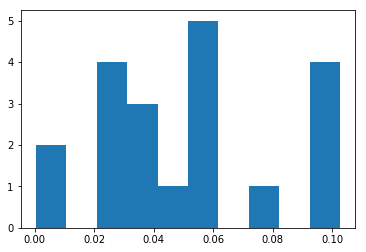

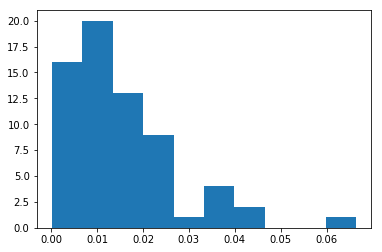

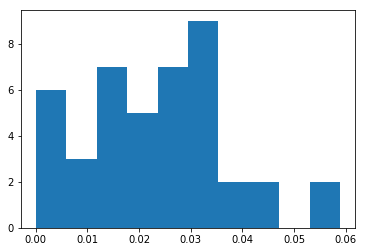

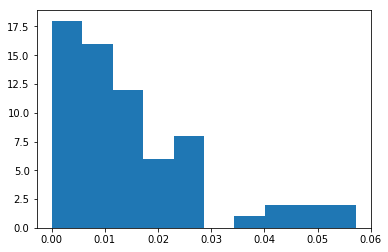

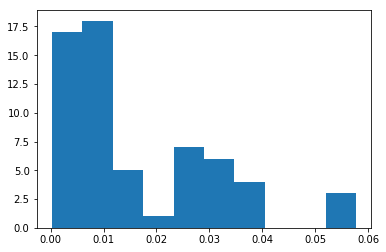

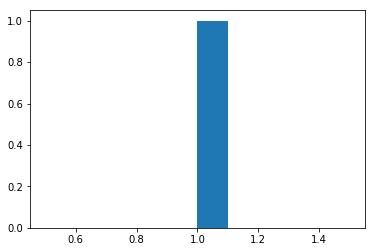

In [20]:
for bor in set(zone_weights.Borough):
    plt.figure()
    plt.hist(zone_weights[zone_weights.Borough == bor].zone_weight.values)

In [21]:
edge_prediction_df = borough_data.copy(deep=True)

In [22]:
boroughs = list(set(zone_weights.Borough))
for bor in boroughs:
    print(bor)
    
    weight_df = zone_weights[zone_weights.Borough == bor]
    
    print(len(weight_df.DOLocationID))
    
    for b_zone,z_weight in zip(weight_df.DOLocationID.values,weight_df.zone_weight.values):        
        edge_prediction_df[b_zone] = edge_prediction_df[bor] * z_weight

Staten Island
20
Manhattan
66
Bronx
43
Queens
67
Brooklyn
61
EWR
1


In [23]:
edge_prediction_df = edge_prediction_df.drop(columns=boroughs)
edge_prediction_df.head(2)

DOLocationID          109       110       115       118       156       172  \
Date       Hour                                                               
2018-01-01 0     0.054100  0.000389  0.060327  0.095161  0.036910  0.048975   
           1     0.108199  0.000778  0.120654  0.190322  0.073819  0.097950   

DOLocationID          176       187       204       206 ...         71  \
Date       Hour                                         ...              
2018-01-01 0     0.036715  0.024779  0.023158  0.102686 ...   1.303137   
           1     0.073430  0.049559  0.046316  0.205371 ...   0.930812   

DOLocationID           72        76        77        80        85        89  \
Date       Hour                                                               
2018-01-01 0     1.550566  3.545607  0.798912  4.302465  0.925072  3.604940   
           1     1.107547  2.532576  0.570651  3.073190  0.660766  2.574957   

DOLocationID           91        97    1  
Date       Hour                           
2018-01-01 0     1.807154  3.171706  1.0  
           1     1.290824  2.265504  0.0  

[2 rows x 258 columns]

In [24]:
edge_data.head(2)

DOLocationID     1  10  100  101  102  106  107  108  109  11 ...  90  91  92  \
Date       Hour                                               ...               
2018-01-01 0     1   7    0    0    0    1    2    1    0   0 ...   3   1   1   
           1     0   4    0    1    0    1    4    0    0   0 ...   3   4   1   

DOLocationID     93  94  95  96  97  98  99  
Date       Hour                              
2018-01-01 0      0   1   6   0   1   0   0  
           1      0   0   2   0   0   0   0  

[2 rows x 258 columns]

In [25]:
edge_prediction_df = edge_prediction_df[edge_data.columns]

In [26]:
r2_score(edge_data.values, edge_prediction_df.values, multioutput='variance_weighted')

0.5744228120278033